# Zillow Single Family Properties

### PLANNING---Acquisition---Preparation---Exploration---Modeling---Delivery
# Project planning:
* Aquire data from MySQL
 
* Prepare data
   * Using my function from prepare, I renamed the columns and droped null values. Additionally I changed datatypes for appropriate columns and renamed fips to actual county names and encoded county.
 
* Explore data in order to find the drivers of the property tax assessed values of single family properties that had a transaction during 2017
   * Answer the following initial questions
       * What are the biggest drivers of higher tax value?
       * Why do some properties have a much higher value than others when they are located so close to each other?
       * Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location?
       * Is having 1 bathroom worse for property value than having 2 bedrooms?
      
* Develop a model to predict the property tax assessed values of single family properties that had a transaction during 2017
   * Use drivers identified in explore to build predictive models of different types
   * Evaluate models on train and validate data
   * Select the best model based on RMSE and r2 scores
   * Evaluate the best model on test data

* My initial hypothesis is that the area of the house and county are the biggest drivers in tax value, because bigger houses cost more and prices of homes vary from county to county.


# Goals:
* Discover the drivers of the property tax assessed values of single family properties that had a transaction during 2017
* Use drivers to develop a machine learning model to predict the property tax assessed values of single family properties that had a transaction during 2017
* Make recommendations on what works or doesn't work in predicting these homes' values.

# My main takeaway: 
# I recommend that we predict the value of single family properties with our polynomial regression model using area, number of bathrooms, and county.

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from env import user, host, password
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from acquire import get_zillow_data, train_val_test, acquire_zillow, wrangle_zillow
import acquire
from prepare import prep_zillow
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor
from prepare import scale_data
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Planning---ACQUISITION---Preparation---Exploration---Modeling---Delivery


# Grabbing the dataset

In [2]:
# Using the get_zillow_data function from acquire
df = get_zillow_data('zillow')

In [3]:
#taking a look
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


### Planning---Acquisition---PREPARATION---Exploration---Modeling---Delivery


# Preparing the data

## Using my function from prepare, I renamed the columns and droped null values.
## Additionally I changed datatypes for appropriate columns
## and renamed fips to actual county names.

In [4]:
# Using my function from prepare, I renamed the columns and droped null values.
# Additionally I changed datatypes for appropriate columns
# and renamed fips to actual county names.
df = prep_zillow(df)
df.T

,4,6,7,11,14,15,18,19,20,21,...,2152850,2152851,2152852,2152853,2152855,2152856,2152858,2152859,2152861,2152862
bedrooms,4,3,3,0,0,0,3,3,3,4,...,3,3,3,4,3,4,4,4,3,4
bathrooms,2.0,4.0,2.0,0.0,0.0,0.0,1.0,2.0,2.0,4.0,...,2.5,3.5,2.0,2.0,2.5,4.0,3.0,4.5,2.5,4.0
area,3633,1620,2077,1200,171,203,1244,1300,1222,4144,...,2033,1980,1917,1987,1809,4375,2262,3127,1974,2110
taxvalue,296425,847770,646760,5328,6920,14166,169471,233266,290492,1303522,...,641757,773358,408680,259913,405547,422400,960756,536061,424353,554009
yearbuilt,2005,2011,1926,1972,1973,1960,1950,1950,1951,2016,...,2015,2014,1946,1955,2012,2015,2015,2014,2015,2014
taxamount,6941.39,10244.94,7924.68,91.6,255.17,163.79,2532.88,3110.99,3870.25,14820.1,...,10009.46,8347.9,4341.32,3175.66,4181.1,13877.56,13494.52,6244.16,5302.7,6761.2
county,LA,LA,LA,LA,LA,LA,LA,LA,LA,LA,...,Orange,Orange,Ventura,Orange,Orange,LA,Orange,Orange,Orange,LA


### Encoding county

In [ ]:
df['county_encoded'] = df.county.map({'LA': 1, 'Orange': 2, 'Ventura': 3})


# Splitting the data

* Using our function from acquire to split the data into samples that we can train, validate, and test machine learning algorithms on


In [ ]:
# Using our function from acquire to split the data into samples that we can train, validate, and test machine learning algorithms on
train, val, test = train_val_test(df)

* Finding the baseline tax value

In [ ]:
# Finding the baseline tax value
baseline = df.taxvalue.mean()
baseline

460641.6251640591

# Scaling the data

* Using my scale data function from my prepare file to scale bedrooms, bathrooms, taxamount, and area within train, validate, and test splits

In [ ]:
# Using my scale data function from my prepare file to scale bedrooms, bathrooms, taxamount, and area within train, validate, and test splits
scaler, train_scaled, validate_scaled, test_scaled = scale_data(train, val, test, return_scaler=True)


### Planning---Acquisition---Preparation---EXPLORATION---modeling---Delivery


# Now we want to find the biggest drivers of value

## For this, we will use a selectkbest model and an RFE model

In [ ]:
X_train_scaled = train_scaled.drop(columns=['taxvalue', 'county', 'taxamount', 'yearbuilt', 'county_encoded'])
y_train_scaled = train_scaled.taxvalue

X_val_scaled = validate_scaled.drop(columns=['taxvalue', 'county', 'taxamount', 'yearbuilt', 'county_encoded'])
y_val_scaled = validate_scaled.taxvalue

X_test_scaled = test_scaled.drop(columns=['taxvalue', 'county', 'taxamount', 'yearbuilt', 'county_encoded'])
y_test_scaled = test_scaled.taxvalue

## Making the SelectKBest model

In [ ]:
# Create the model
kbest = SelectKBest(score_func=f_regression, k=3)
# Fit
kbest.fit(X_train_scaled, y_train_scaled)


SelectKBest(k=3, score_func=<function f_regression at 0x13ff09120>)

In [ ]:
# Create the mask
feature_mask = kbest.get_support()


In [ ]:
# Now we are going to ask for the column names of select k best top 3 features
X_train_scaled.columns[feature_mask]

Index(['bedrooms', 'bathrooms', 'area'], dtype='object')

## Making the RFE model

In [ ]:
# Create the algorithm
lm = LinearRegression()

In [ ]:
# Assign the number of feature
rfe = RFE(estimator=lm, n_features_to_select=3)

In [ ]:
# Now we are fitting those features to our train set
X_rfe = rfe.fit(X_train_scaled, y_train_scaled)

In [ ]:
# Create a variable that takes X_train and turns rfe features into a list
rfe_columns = X_train_scaled.columns[rfe.support_].tolist()
# Call the variable
rfe_columns

['bedrooms', 'bathrooms', 'area']

## The biggest drivers in both models are bedrooms, bathrooms, and area

## Let's look at how the features correlate with each other and tax value

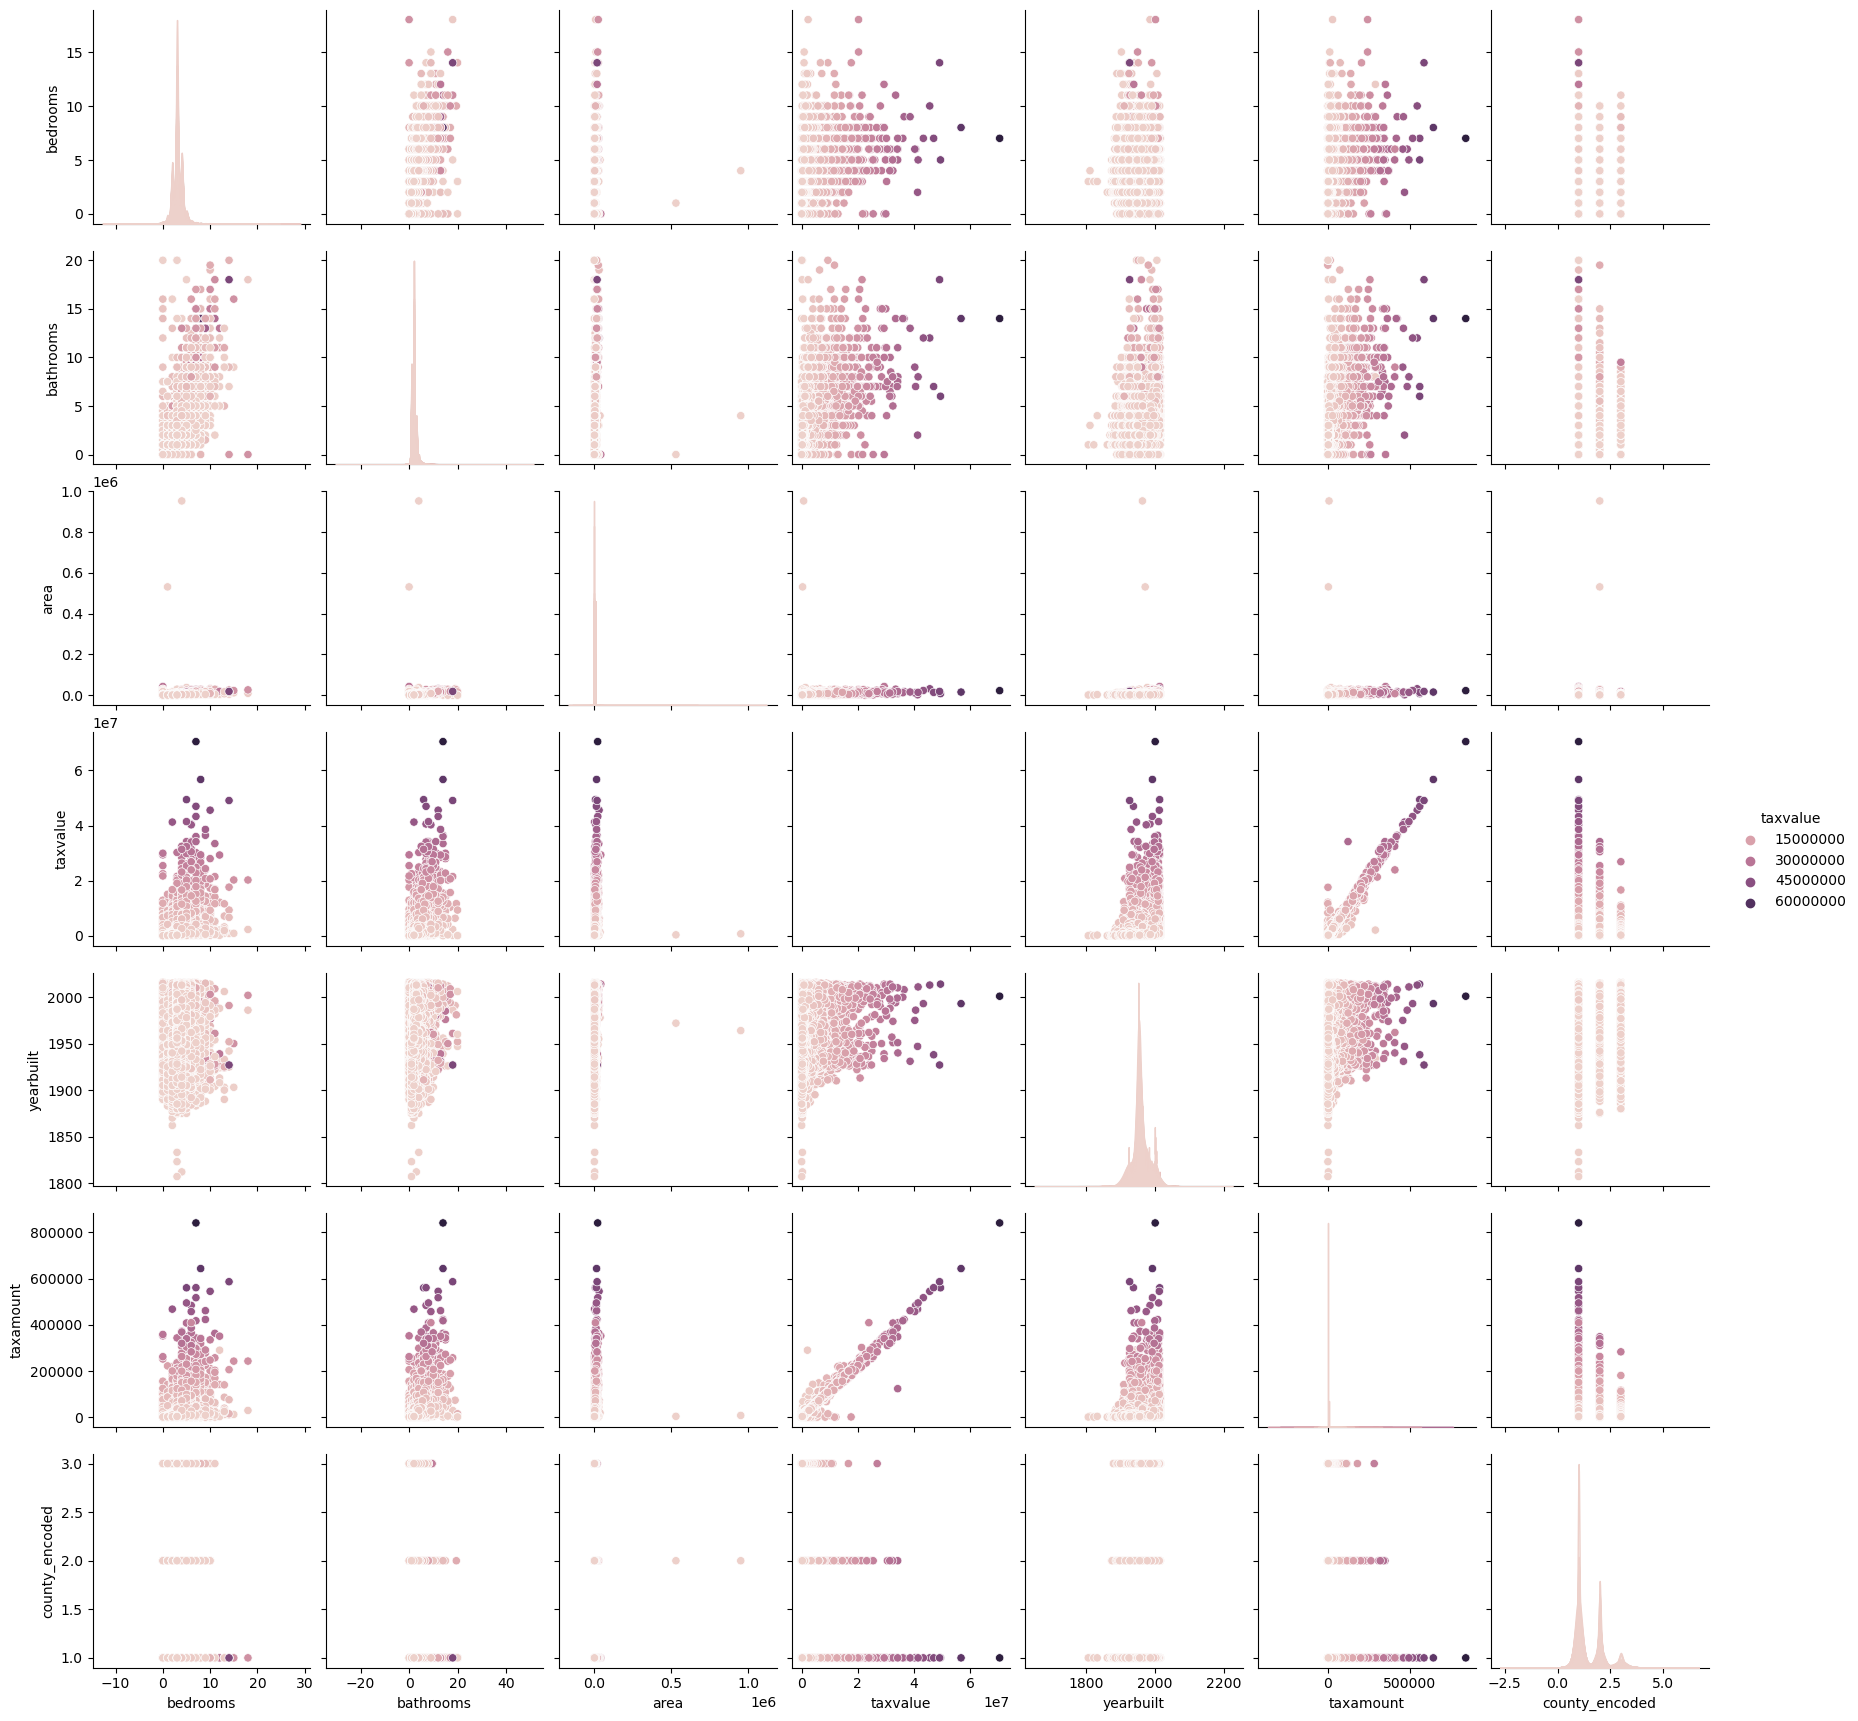

In [ ]:
# This will take about an hour to run
#quan= []
#for col in train:
#    if ((train[col].dtype=='float64') | (train[col].dtype=='int')):
#        quan.append(col)
#sns.pairplot(data=train, vars=quan, hue='taxvalue')
#plt.show()

## Initial takeaways: LA has the highest value and is likely the biggest driver of value besides area, newer houses have higher value, area is too close on this graph but the other tests show correlation, bedrooms seem to be worth the most in the average amount so it is likely not a strong driver, and amount of bathrooms does generally increase value, and although the more expensive houses have more bathrooms, there are still many less expensive houses that have more bathrooms. 

### Planning---Acquisition---Preparation---Exploration---MODELING---Delivery


## Let's make a function to show our RMSE and r2 from our models

In [ ]:
# Let's make a function to show our RMSE and r2 from our models
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2
baseline_array = np.repeat(baseline, len(train))
baseline_array[:5]

array([460641.62516406, 460641.62516406, 460641.62516406, 460641.62516406,
       460641.62516406])

In [ ]:
rmse, r2 = metrics_reg(y_train_scaled, baseline_array)
rmse, r2

(665378.0019892772, -1.8280535840631273e-07)

## Now we'll make a dataframe to compare our models

In [ ]:
# Now we'll make a dataframe to compare our models
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

,model,rmse,r2
0,baseline,665378.001989,-1.828054e-07


## Our baseline does not predict very much as it is close to zero

## Let's try an OLS model

In [ ]:
# Intial ML model
lr1 = LinearRegression()

# Make it
rfe = RFE(lr1, n_features_to_select=1)

# Fit it
rfe.fit(X_train_scaled, y_train_scaled)

# Use it on train
X_train_rfe = rfe.transform(X_train_scaled)

# Use it on validate
X_val_rfe = rfe.transform(X_val_scaled)


In [ ]:
# Fit the thing
lr1.fit(X_train_rfe, y_train_scaled)

# Use the thing (make predictions)
pred_lr1 = lr1.predict(X_train_rfe)
pred_val_lr1 = lr1.predict(X_val_rfe)

## Evaluating our model

In [ ]:
# Train
metrics_reg(y_train_scaled, pred_lr1)

(601237.3378573689, 0.18350206903796717)

In [ ]:
# Validate
rmse, r2 = metrics_reg(y_val_scaled, pred_val_lr1)
rmse, r2

(578547.2545996245, 0.27127543133129484)

In [ ]:
# Add to my metrics df
metrics_df.loc[1] = ['ols_1', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,665378.001989,-1.828054e-07
1,ols_1,578547.254600,2.712754e-01


## Let's try a polynomial regression model

In [ ]:
# Make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# Fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# Transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_val_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [ ]:
# Make it
pr = LinearRegression()

# Fit it
pr.fit(X_train_degree2, y_train_scaled)

# Use it
pred_pr = pr.predict(X_train_degree2)
pred_val_pr = pr.predict(X_validate_degree2)

## Evaluating our model

In [ ]:
# Train
metrics_reg(y_train_scaled, pred_pr)

(487610.5476318333, 0.4629565984056826)

In [ ]:
# Validate
rmse, r2 = metrics_reg(y_val_scaled, pred_val_pr)
rmse, r2

(502867.62094248063, 0.4494546696652797)

In [ ]:
# Add to my metrics df
metrics_df.loc[4] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,665378.001989,-1.828054e-07
1,ols_1,578547.254600,2.712754e-01
2,ols,561763.904745,3.129420e-01
3,lars,561901.788965,3.126047e-01
4,poly_2,502867.620942,4.494547e-01


## Our polynomial regression model is our best one yet! Let's try out a tweedie regression model and see if it performs better

In [ ]:
# Make it
glm = TweedieRegressor(power=0, alpha=0)

# Fit it
glm.fit(X_train_scaled, y_train_scaled)

# Use it
pred_glm = glm.predict(X_train_scaled)
pred_val_glm = glm.predict(X_val_scaled)

## Evaluating our model

In [ ]:
# Train
metrics_reg(y_train_scaled, pred_glm)

(556425.1972657981, 0.30067866319520997)

In [ ]:
# Validate
rmse, r2 = metrics_reg(y_val_scaled, pred_val_glm)
rmse, r2

(562181.2590228381, 0.3119207436008251)

In [ ]:
# Add to my metrics df
metrics_df.loc[5] = ['glm',rmse,r2]
metrics_df

,model,rmse,r2
0,baseline,665378.001989,-1.828054e-07
1,ols_1,578547.254600,2.712754e-01
2,ols,561763.904745,3.129420e-01
3,lars,561901.788965,3.126047e-01
4,poly_2,502867.620942,4.494547e-01
5,glm,562181.259023,3.119207e-01


## Our Tweedie model does not out-perform our polynomial model, so we will evaluate test on our polynomial model

In [ ]:
# Use it
pred_test = pr.predict(X_test_degree2)
pred_test

array([353114.9406866 , 259283.25900824, 420768.67780312, ...,
       438067.30859092, 245534.39380948, 316503.43068384])

In [ ]:
rmse, r2 = metrics_reg(y_test_scaled, pred_test)
rmse, r2

(505781.791117735, 0.4902964441635177)

## This model performs well on all three splits

### Let's look at how far our polynomial model was from actual tax value

In [ ]:
X_train = train.drop(columns=['taxvalue', 'county', 'taxamount', 'county_encoded', 'yearbuilt'])
y_train = train.taxvalue


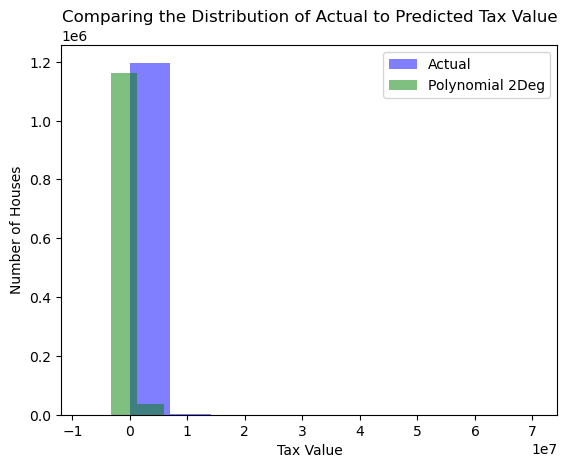

In [ ]:
plt.hist(y_train, color='blue', alpha=.5, label="Actual")
plt.hist(pred_pr, color='green', alpha=.5, label="Polynomial 2Deg")

plt.xlabel("Tax Value")
plt.ylabel("Number of Houses")
plt.title("Comparing the Distribution of Actual to Predicted Tax Value")
plt.legend()
plt.show()

## Let's run stats tests to confirm our drivers

## We will test this using Pearson's r because there are two continuous variables

## let's test bathrooms

H
0
 : there is no linear correlation between bathrooms and tax value

H
a
 : there is a linear correlation between bathrooms and tax value

In [ ]:
alpha = 0.05
r, p = stats.pearsonr(X_train.bathrooms, y_train)
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


## There is a correlation with bathrooms and a higher tax value. Let's test area

H
0
 : there is no linear correlation between area and tax value

H
a
 : there is a linear correlation between area and tax value

In [ ]:
r, p = stats.pearsonr(X_train.area, y_train)
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


## There is a correlation with area and a higher tax value, as well

## Finally, let's test our one discrete feature, county, with a t test

### We'll see if LA is a driver

In [ ]:
LA_value = train[train.county_encoded == 1]['taxvalue']
not_la_value = train[train.county_encoded != 1]['taxvalue']
t_stat, p = stats.ttest_ind(LA_value, not_la_value, equal_var=True)
if p < alpha:
    print('Reject the null hypothesis. Meaning, There is an association between LA and higher tax value. They are not independent.')
else:
    print('Fail to reject the null. Meaning, There is not an association between LA and higher tax value. They are independent.')

Reject the null hypothesis. Meaning, There is an association between LA and higher tax value. They are not independent.


### Planning---Acquisition---Preparation---Exploration---Modeling---DELIVERY


# My main takeaways are:
# The biggest drivers of higher value are larger area, if the house is in LA, and more bathrooms.
## Some properties have a much higher value than others when they are located so close to each other because area and number of bedrooms and bathrooms are higher, which is tied to a higher value.
## Some properties are valued so differently from others when they have nearly the same physical attributes but only differ in location because value is highest in LA, less in Orange County, and significantly less in Ventura County.
## Having 1 bathroom is not worse for property value than having 2 bedrooms



# I recommend that we predict the value of single family properties with our polynomial regression model using area, number of bathrooms, and county.